1\. **Color-coded scatter plot**

Produce a scatter plot from a dataset with two categories.

* Write a function that generates a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and standard deviation. Set different values of the mean and stardand deviation between the two samples.
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below:

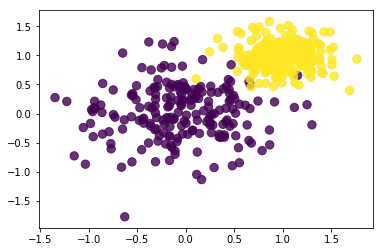

In [1]:
from IPython.display import Image
Image('two_categories_scatter_plot.png')

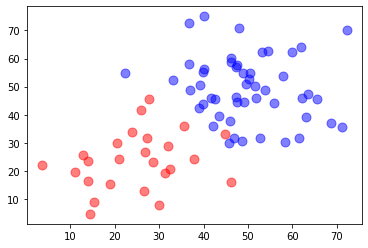

In [57]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline

# Assumption: There are no correlation between the two axes. Then 2D Gaussian can be done by calling 1D gaussian twice.
def randCreator(mean1, standartDev1, mean2, standartDev2):
    a = mean1 + standartDev1 * np.random.randn(mean1, mean1)
    b = mean2 + standartDev2 * np.random.randn(mean2, mean2)
    return a,b


a,b = randCreator(50,-10,25,10)
plt.scatter(a[0],a[1], c='b', s=80, alpha=0.5)
plt.scatter(b[0],b[1], c='r', s=80, alpha=0.5)
plt.show()

2\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following pickle file:
```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```
* Inspect the dataset, you'll find two variables (features)
* Convert the content to a Pandas Dataframe
* Clean the sample by selecting the entries (rows) with the absolute values of the variable "residual" smaller than 2
* Plot a Seaborn jointplot of "residuals" versus "distances", and use seaborn to display a linear regression. 

Comment on the correlation between these variables.

* Create manually (without using seaborn) the profile histogram for the "distance" variable; choose an appropriate binning.
* Obtain 3 numpy arrays:
  * `x`, the array of bin centers of the profile histogram of the "distance" variable
  * `y`, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * `err_y`, the standard deviation of the of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11131 entries, 0 to 11130
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   residuals  11131 non-null  float64
 1   distances  11131 non-null  float64
dtypes: float64(2)
memory usage: 174.0 KB
*********
slope = -0.015435375623424168  intercept = 6.637880474395569  r_value = -0.0419358816530077  p_value = 0.28908737626979863  stderr = 0.014547848854062915
*********
(array([309, 156, 110,  63], dtype=int64), array([ 0,  5, 10, 15, 20]))
*********
distances
(0, 5]      -9.017777
(5, 10]     -8.306490
(10, 15]    -4.686396
(15, 20]   -14.540059
Name: mean, dtype: float64
*********
distances
(0, 5]      13.196083
(5, 10]     14.850408
(10, 15]     7.895494
(15, 20]    27.549108
Name: std, dtype: float64


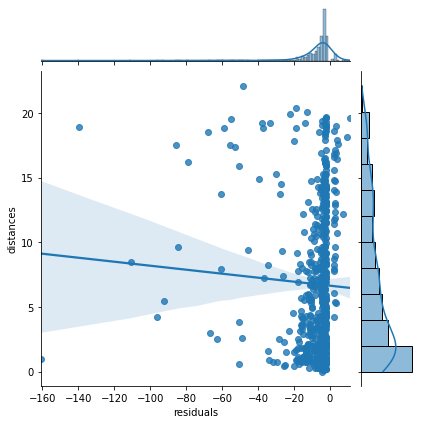

In [41]:
from scipy import stats
import seaborn as sns

data=np.load("data/residuals_261.pkl",allow_pickle=True).item()
df=pd.DataFrame(data)
df.info()
print("*********")
###
abs_mask = (df['residuals']<-2) | (df['residuals']>2)
df = df[abs_mask]
###
X = df.residuals
Y = df.distances
#Linear regression:
slope, intercept, r_value, p_value, stderr = stats.linregress(X, Y)
print("slope =",slope," intercept =",intercept," r_value =",r_value," p_value =",p_value," stderr =",stderr)
print("*********")
#seaborn plot
sns.jointplot(data=df, x="residuals", y="distances", kind="reg")
###
dist=np.array(df.distances)
x=[0,5,10,15,20] # bin array
#print(dist)
dist_hist=np.histogram(dist,bins = x ) 
print(dist_hist)
###
#mean and  the standard deviation of the of the "residuals", estimated in slices (bins) of "distance"
mean_std=df.groupby(pd.cut(df['distances'], bins=x))['residuals'].agg(['mean','std'])
y = mean_std['mean']
err_y = mean_std['std']
print("*********")
print(y)
print("*********")
print(err_y)

3\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn):

* Fill a numpy array `x` of length N (with $N=\mathcal{O}(100)$) with a variable normally distributed, with a given mean and standard deviation
* Fill an histogram in pyplot taking proper care of the aesthetic:
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* For every element of `x`, create a gaussian with the mean corresponding to the element value and the standard deviation as a parameter that can be tuned. The standard deviation default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with `np.sum()`) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method. Superimpose the normalized sum of all gaussians to the first histogram.


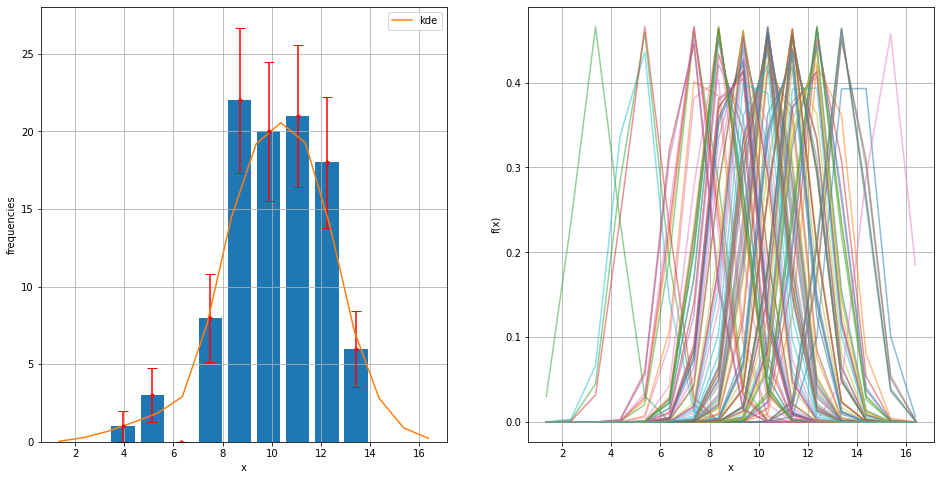

In [45]:
import scipy.stats
from scipy import integrate

### 1 normally dist. arr
mu, sigma = 10, 2 # mean & std
N=100
x = np.random.normal(mu, sigma, N)
### 2 histogram
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

bin_number=10
bins=np.arange(x.min(), x.max(), (x.max()-x.min())/bin_number)
freq, bins, patches = ax1.hist(x=x, bins=bins,alpha=1, histtype='bar', rwidth=0.8)

ax1.grid()
ax1.set_xlabel('x')
ax1.set_ylabel('frequencies')

### 3 error
bincenters = (bins[1:] + bins[:-1])/2
ax1.errorbar(x=bincenters, y=freq, yerr=np.sqrt(freq), fmt='o', c='r', marker='*', markersize=4, capsize=5)

### 4 gaussian
std_dev = 1.06 * x.std() * (x.size ** -0.2)
xrange = np.arange(x.min()-sigma, x.max()+sigma)
gaussians = []
for i, dat in enumerate(x):
    gaussians.append( stats.norm(loc=dat, scale=std_dev).pdf(xrange) )
    ax2.plot(xrange, gaussians[i], alpha=0.5)
ax2.set_xlabel('x')
ax2.set_ylabel('f(x)')
ax2.grid()

### 5 sum of all gaussians
area=integrate.trapz(freq, dx=bins[1]-bins[0])
kde=np.array(gaussians).sum(axis=0)
ax1.plot(xrange,kde/sum(kde)*area,label='kde')
ax1.legend()

plt.show()